# Mount drive

In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Install dependencies

In [2]:
!pip install discopy==1.1.4
!pip install lambeq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.9/144.9 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.1/152.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.3/364.3 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 11.2 MB/s eta 0:00:00


# Import libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# QNLP
from lambeq.tokeniser import SpacyTokeniser
from lambeq import BobcatParser, spiders_reader, cups_reader, TreeReader, TreeReaderMode, stairs_reader
from lambeq import Rewriter, SimpleRewriteRule, remove_cups, AtomicType, TensorAnsatz, SpiderAnsatz
from discopy.tensor import Dim
from discopy.grammar.pregroup import Cap, Id, Diagram
S = AtomicType.SENTENCE
N = AtomicType.NOUN
P = AtomicType.PREPOSITIONAL_PHRASE
C = AtomicType.CONJUNCTION

# Training
from lambeq import PytorchModel, PytorchTrainer, Dataset, BinaryCrossEntropyLoss
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

# SEED for reproducibility
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Load data

In [4]:
QUANTUM_PATH = '/content/drive/MyDrive/Tesi/Master-Thesis/data/processed/quantum.csv'
CLASSICAL_PATH = '/content/drive/MyDrive/Tesi/Master-Thesis/data/processed/classical.csv'

df = pd.read_csv(CLASSICAL_PATH, index_col=False)

# SE_CLASSICAL_DS_PATH = '/content/drive/MyDrive/Tesi/Master-Thesis/data/processed/balanced/classical_SE.csv'
# US_CLASSICAL_DS_PATH = '/content/drive/MyDrive/Tesi/Master-Thesis/data/processed/balanced/classical_US.csv'
# O_CLASSICAL_DS_PATH = '/content/drive/MyDrive/Tesi/Master-Thesis/data/processed/balanced/classical_O.csv'
# PE_CLASSICAL_DS_PATH = '/content/drive/MyDrive/Tesi/Master-Thesis/data/processed/balanced/classical_PE.csv'

# se_df = pd.read_csv(SE_CLASSICAL_DS_PATH, index_col=False)
# us_df = pd.read_csv(US_CLASSICAL_DS_PATH, index_col=False)
# o_df = pd.read_csv(O_CLASSICAL_DS_PATH, index_col=False)
# pe_df = pd.read_csv(PE_CLASSICAL_DS_PATH, index_col=False)

# Create string-diagrams
Uncomment rows for different readers

In [5]:
def create_binary_diagrams(df, reader):
    diagrams = []
    se_targets, us_targets, o_targets, pe_targets = [], [], [], []
    for _, row in enumerate(df.to_numpy()):
        sentence, target = row[0], row[1]
        try:
            diagrams.append(reader.sentence2diagram(sentence))
        except Exception as e:
            print(sentence)
            print(e)
            continue
        if target == "SE":
            se_targets.append([1.0, 0.0])
            us_targets.append([0.0, 1.0])
            o_targets.append([0.0, 1.0])
            pe_targets.append([0.0, 1.0])
        elif target == "US":
            se_targets.append([0.0, 1.0])
            us_targets.append([1.0, 0.0])
            o_targets.append([0.0, 1.0])
            pe_targets.append([0.0, 1.0])
        elif target == "O":
            se_targets.append([0.0, 1.0])
            us_targets.append([0.0, 1.0])
            o_targets.append([1.0, 0.0])
            pe_targets.append([0.0, 1.0])
        elif target == "PE":
            se_targets.append([0.0, 1.0])
            us_targets.append([0.0, 1.0])
            o_targets.append([0.0, 1.0])
            pe_targets.append([1.0, 0.0])
    return diagrams, se_targets, us_targets, o_targets, pe_targets

reader = spiders_reader
# reader = cups_reader
# reader = stairs_reader
# reader = TreeReader(ccg_parser=BobcatParser, mode = TreeReaderMode.RULE_TYPE)

# reader = BobcatParser(root_cats=['S'])

diagrams, se_targets, us_targets, o_targets, pe_targets = create_binary_diagrams(df, reader)

# Rewrite string-diagrams
This step is not performed for linear readers (spiders, cups, etc.).

In [6]:
# def normalize_diagrams(diagrams):
#     normalized_diagrams = []
#     for i, diagram in enumerate(diagrams):
#         try:
#             normalized_diagrams.append(rewriter(diagram).normal_form())
#         except Exception as e:
#             print(e)
#             diagram.draw()
#             continue
#     return normalized_diagrams

# import nltk
# nltk.download('punkt')

# from nltk.probability import FreqDist
# from nltk.tokenize import word_tokenize
# from lambeq import UnknownWordsRewriteRule

# all_words = [word for tokens in se_df['RequirementText'].apply(lambda x: word_tokenize(x)) for word in tokens]
# freq_dist = FreqDist(all_words)
# common_words = [word for word, freq in freq_dist.items() if freq >= 2]

# unknown_rule = UnknownWordsRewriteRule(common_words)

# rewriter = Rewriter(['prepositional_phrase', 'determiner', 'connector', 'auxiliary', 'preadverb', 'coordination'])
# diagrams = normalize_diagrams(diagrams)

# Parameterize diagrams
Uncomment rows for different anstaze

In [7]:
def create_networks(diagrams, ansatz):
    networks = []
    for i, diagram in enumerate(diagrams):
        try:
            networks.append(ansatz(remove_cups(diagram)))
        except Exception as e:
            print(e)
            diagram.draw(figsize=(8,5), fontsize=8)
            continue
    return networks

ob_map = {
    S: Dim(2),
    N: Dim(2),
    P: Dim(2)
}

ansatz = TensorAnsatz(ob_map)

networks = create_networks(diagrams, ansatz)

# # check for codomain errors
# for i,c in enumerate(networks):
#     if str(c.cod) != 'Dim(2)':
#         networks[i].draw()

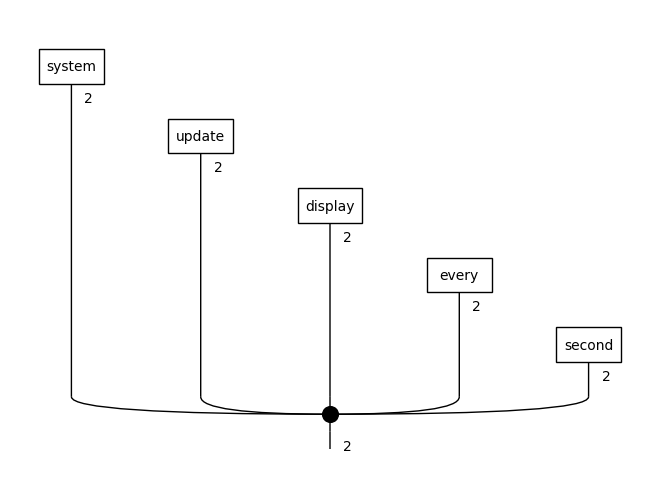

In [8]:
networks[0].draw()

# Define evalutation metrics

In [9]:
def accuracy(y_hat, y):
    y_true = torch.argmax(y, dim=1)
    y_pred = torch.argmax(y_hat, dim=1)
    return accuracy_score(y_true, y_pred)

def precision(y_hat, y):
    y_true = torch.argmax(y, dim=1)
    y_pred = torch.argmax(y_hat, dim=1)
    return precision_score(y_true, y_pred, zero_division=1)

def recall(y_hat, y):
    y_true = torch.argmax(y, dim=1)
    y_pred = torch.argmax(y_hat, dim=1)
    return recall_score(y_true, y_pred, zero_division=1)

def f1score(y_hat, y):
    y_true = torch.argmax(y, dim=1)
    y_pred = torch.argmax(y_hat, dim=1)
    return f1_score(y_true, y_pred, zero_division=1)

eval_metrics = {"prec": precision, "rec": recall, "acc": accuracy, "f1": f1score}

# Define model

In [96]:
class ClassicalModel(PytorchModel):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        x = self.get_diagram_output(input)
        return x

# Training

In [93]:
EPOCHS = 100
SPLIT = 10
EARLY_STOPPING = None

custom_primary = '#007FFF'
custom_secondary = '#FF6666'

## Grid Search

Epoch 5:    train/loss: 0.6455   valid/loss: 0.6965   train/prec: 0.6447   train/rec: 1.0000   train/acc: 0.6447   train/f1: 0.7799   valid/prec: 0.6286   valid/rec: 0.9565   valid/acc: 0.6111   valid/f1: 0.7586
Epoch 10:   train/loss: 0.4032   valid/loss: 0.7110   train/prec: 0.8794   train/rec: 0.8018   train/acc: 0.8082   train/f1: 0.8365   valid/prec: 0.7333   valid/rec: 0.4783   valid/acc: 0.5556   valid/f1: 0.5789
Epoch 15:   train/loss: 0.1297   valid/loss: 0.9668   train/prec: 0.9822   train/rec: 0.8760   train/acc: 0.9119   train/f1: 0.9243   valid/prec: 0.8462   valid/rec: 0.4783   valid/acc: 0.6111   valid/f1: 0.6111
Epoch 20:   train/loss: 0.1265   valid/loss: 1.3401   train/prec: 0.9956   train/rec: 0.9346   train/acc: 0.9560   train/f1: 0.9637   valid/prec: 0.9333   valid/rec: 0.6087   valid/acc: 0.7222   valid/f1: 0.7368
Epoch 25:   train/loss: 0.0105   valid/loss: 2.0624   train/prec: 1.0000   train/rec: 0.9667   train/acc: 0.9811   train/f1: 0.9824   valid/prec: 0.9375

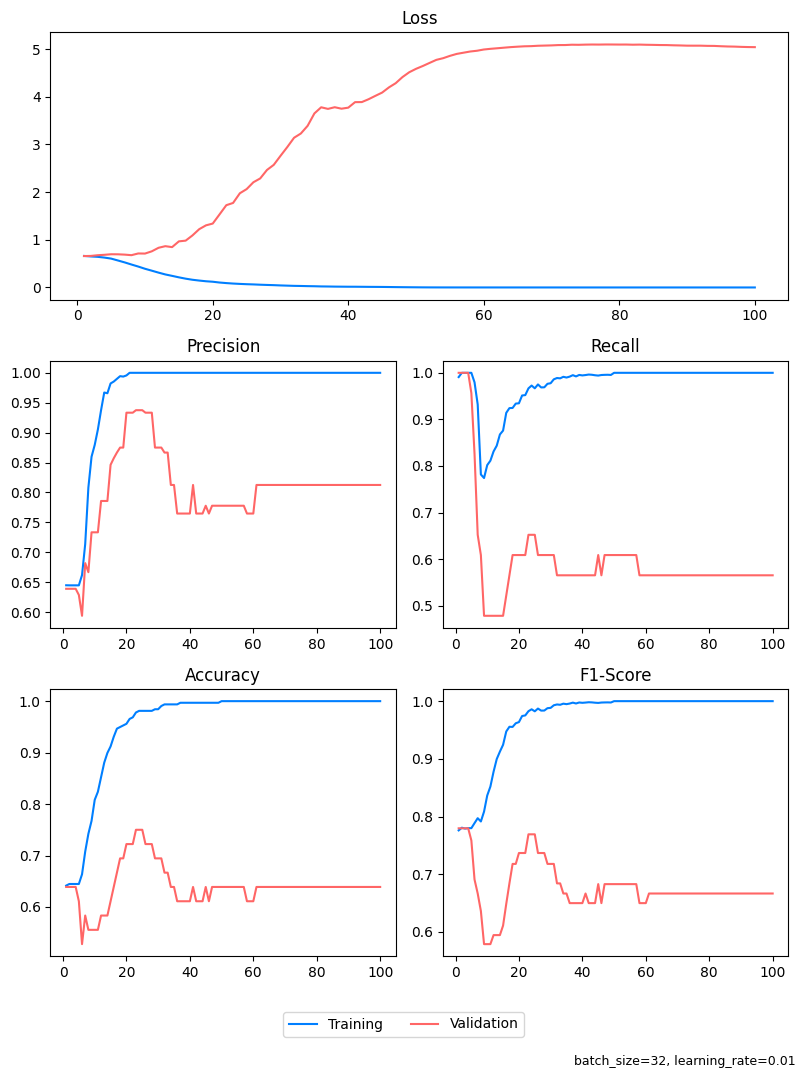

Epoch 5:    train/loss: 0.4888   valid/loss: 0.6587   train/prec: 0.8591   train/rec: 0.7740   train/acc: 0.7642   train/f1: 0.8090   valid/prec: 0.7647   valid/rec: 0.5652   valid/acc: 0.6111   valid/f1: 0.6500
Epoch 10:   train/loss: 0.0815   valid/loss: 0.7625   train/prec: 0.9950   train/rec: 0.9607   train/acc: 0.9717   train/f1: 0.9773   valid/prec: 0.8095   valid/rec: 0.7391   valid/acc: 0.7222   valid/f1: 0.7727
Epoch 15:   train/loss: 0.0088   valid/loss: 1.5085   train/prec: 0.9956   train/rec: 0.9851   train/acc: 0.9874   train/f1: 0.9901   valid/prec: 0.7895   valid/rec: 0.6522   valid/acc: 0.6667   valid/f1: 0.7143
Epoch 20:   train/loss: 0.0079   valid/loss: 2.0363   train/prec: 1.0000   train/rec: 0.9954   train/acc: 0.9969   train/f1: 0.9977   valid/prec: 0.8333   valid/rec: 0.6522   valid/acc: 0.6944   valid/f1: 0.7317
Epoch 25:   train/loss: 0.0010   valid/loss: 2.3993   train/prec: 1.0000   train/rec: 0.9952   train/acc: 0.9969   train/f1: 0.9975   valid/prec: 0.7368

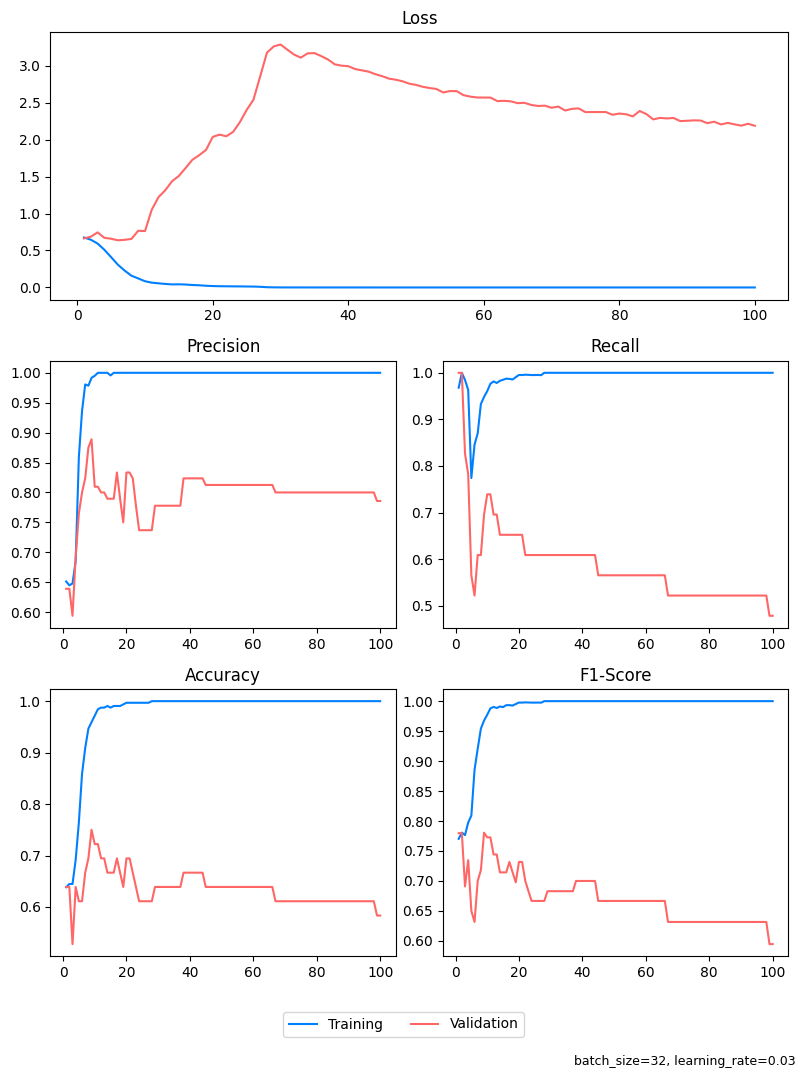

Epoch 5:    train/loss: 0.3760   valid/loss: 0.6240   train/prec: 0.9783   train/rec: 0.8381   train/acc: 0.8868   train/f1: 0.9002   valid/prec: 0.7895   valid/rec: 0.6522   valid/acc: 0.6667   valid/f1: 0.7143
Epoch 10:   train/loss: 0.0053   valid/loss: 1.0461   train/prec: 1.0000   train/rec: 0.9801   train/acc: 0.9874   train/f1: 0.9898   valid/prec: 0.8750   valid/rec: 0.6087   valid/acc: 0.6944   valid/f1: 0.7179
Epoch 15:   train/loss: 0.0048   valid/loss: 2.1470   train/prec: 1.0000   train/rec: 0.9907   train/acc: 0.9937   train/f1: 0.9952   valid/prec: 0.8235   valid/rec: 0.6087   valid/acc: 0.6667   valid/f1: 0.7000
Epoch 20:   train/loss: 0.0103   valid/loss: 2.4182   train/prec: 1.0000   train/rec: 0.9911   train/acc: 0.9937   train/f1: 0.9954   valid/prec: 0.8235   valid/rec: 0.6087   valid/acc: 0.6667   valid/f1: 0.7000
Epoch 25:   train/loss: 0.0043   valid/loss: 2.8362   train/prec: 1.0000   train/rec: 0.9893   train/acc: 0.9937   train/f1: 0.9945   valid/prec: 0.8235

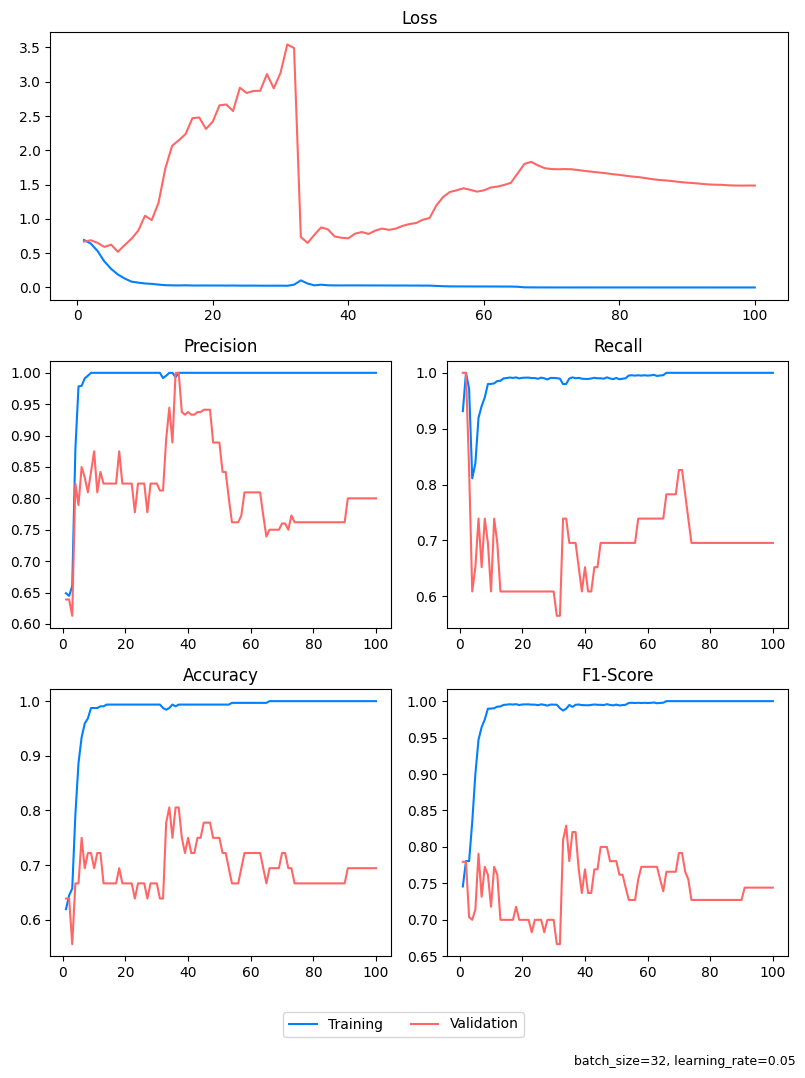

Epoch 5:    train/loss: 0.6100   valid/loss: 0.6797   train/prec: 0.6447   train/rec: 1.0000   train/acc: 0.6447   train/f1: 0.7835   valid/prec: 0.6389   valid/rec: 1.0000   valid/acc: 0.6389   valid/f1: 0.7797
Epoch 10:   train/loss: 0.5342   valid/loss: 0.6607   train/prec: 0.7421   train/rec: 0.8829   train/acc: 0.7233   train/f1: 0.8050   valid/prec: 0.7083   valid/rec: 0.7391   valid/acc: 0.6389   valid/f1: 0.7234
Epoch 15:   train/loss: 0.3228   valid/loss: 0.6464   train/prec: 0.9377   train/rec: 0.8146   train/acc: 0.8428   train/f1: 0.8693   valid/prec: 0.8000   valid/rec: 0.5217   valid/acc: 0.6111   valid/f1: 0.6316
Epoch 20:   train/loss: 0.1669   valid/loss: 0.5704   train/prec: 0.9900   train/rec: 0.9214   train/acc: 0.9434   train/f1: 0.9541   valid/prec: 0.8235   valid/rec: 0.6087   valid/acc: 0.6667   valid/f1: 0.7000
Epoch 25:   train/loss: 0.0697   valid/loss: 0.6226   train/prec: 1.0000   train/rec: 0.9581   train/acc: 0.9748   train/f1: 0.9783   valid/prec: 0.8824

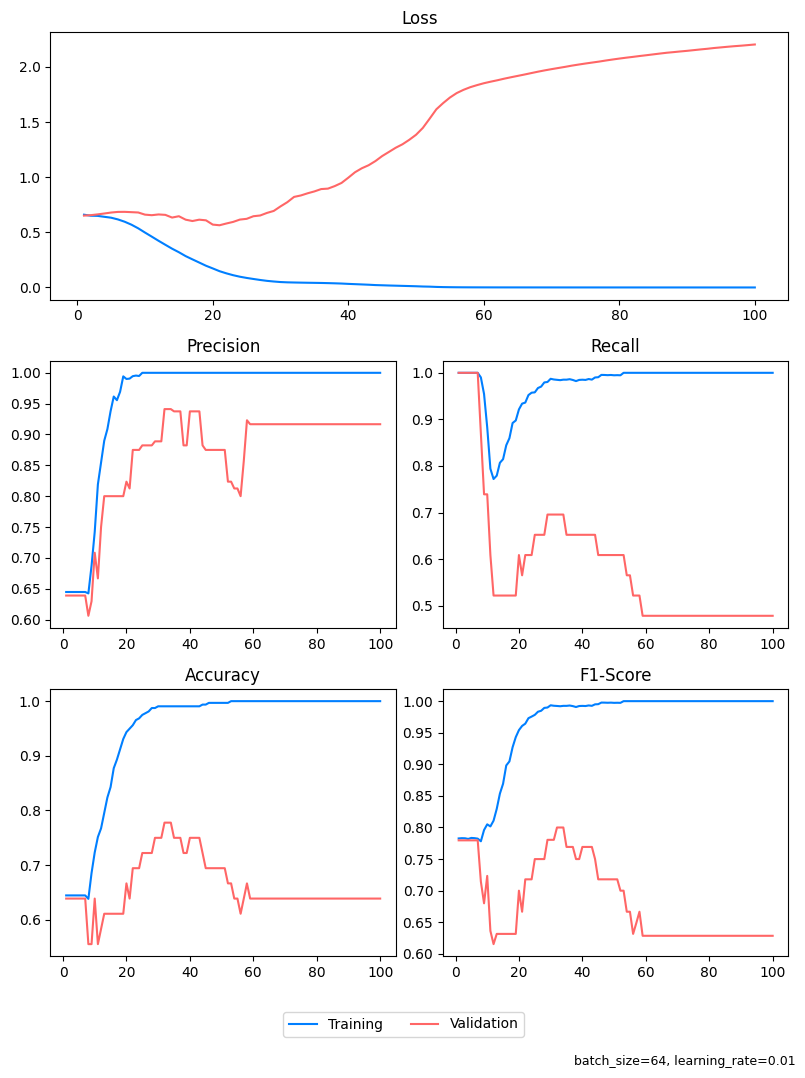

Epoch 5:    train/loss: 0.5369   valid/loss: 0.6531   train/prec: 0.6651   train/rec: 0.9673   train/acc: 0.6604   train/f1: 0.7858   valid/prec: 0.7200   valid/rec: 0.7826   valid/acc: 0.6667   valid/f1: 0.7500
Epoch 10:   train/loss: 0.1221   valid/loss: 0.3979   train/prec: 0.9954   train/rec: 0.9283   train/acc: 0.9497   train/f1: 0.9604   valid/prec: 0.9048   valid/rec: 0.8261   valid/acc: 0.8333   valid/f1: 0.8636
Epoch 15:   train/loss: 0.0076   valid/loss: 0.5373   train/prec: 1.0000   train/rec: 0.9863   train/acc: 0.9906   train/f1: 0.9929   valid/prec: 0.9474   valid/rec: 0.7826   valid/acc: 0.8333   valid/f1: 0.8571
Epoch 20:   train/loss: 0.0087   valid/loss: 0.6079   train/prec: 1.0000   train/rec: 0.9899   train/acc: 0.9937   train/f1: 0.9949   valid/prec: 0.9000   valid/rec: 0.7826   valid/acc: 0.8056   valid/f1: 0.8372
Epoch 25:   train/loss: 0.0027   valid/loss: 0.8630   train/prec: 1.0000   train/rec: 0.9946   train/acc: 0.9969   train/f1: 0.9972   valid/prec: 0.9375

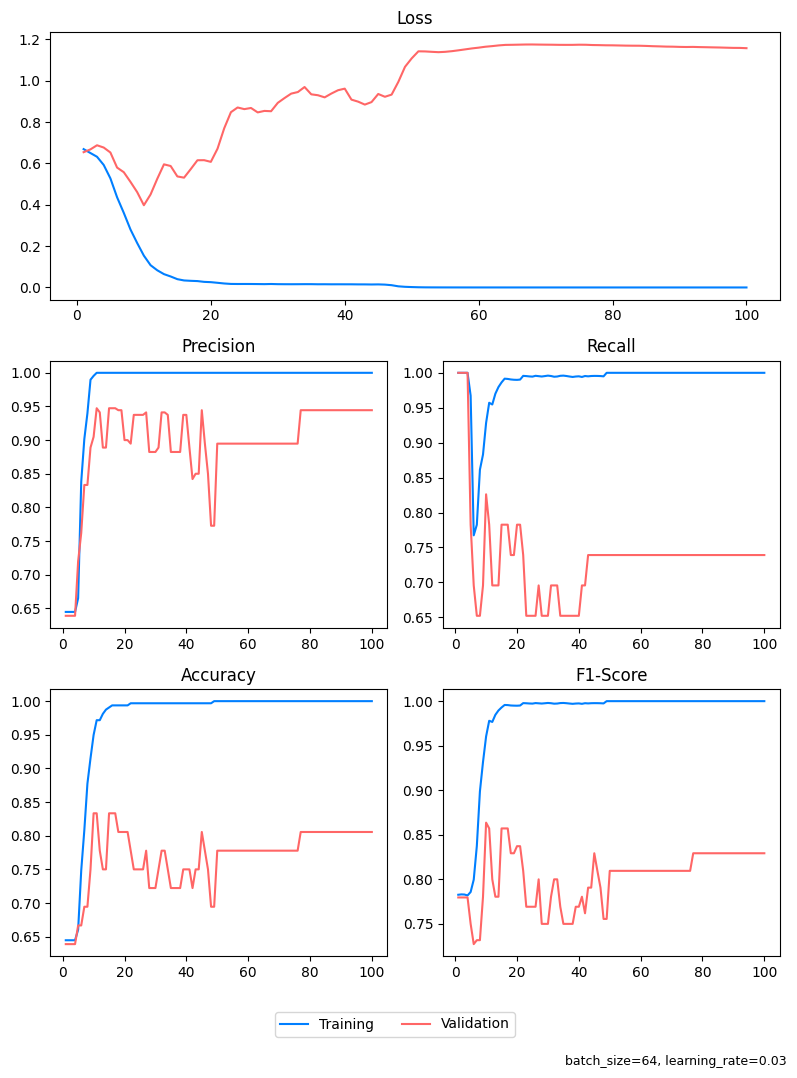

Epoch 5:    train/loss: 0.5061   valid/loss: 0.6043   train/prec: 0.7931   train/rec: 0.8756   train/acc: 0.7579   train/f1: 0.8234   valid/prec: 0.7500   valid/rec: 0.6522   valid/acc: 0.6389   valid/f1: 0.6977
Epoch 10:   train/loss: 0.0675   valid/loss: 0.5826   train/prec: 0.9950   train/rec: 0.9614   train/acc: 0.9717   train/f1: 0.9778   valid/prec: 0.9048   valid/rec: 0.8261   valid/acc: 0.8333   valid/f1: 0.8636
Epoch 15:   train/loss: 0.0054   valid/loss: 0.8404   train/prec: 1.0000   train/rec: 0.9909   train/acc: 0.9937   train/f1: 0.9953   valid/prec: 0.8182   valid/rec: 0.7826   valid/acc: 0.7500   valid/f1: 0.8000
Epoch 20:   train/loss: 0.0035   valid/loss: 0.7954   train/prec: 1.0000   train/rec: 0.9952   train/acc: 0.9969   train/f1: 0.9976   valid/prec: 0.9000   valid/rec: 0.7826   valid/acc: 0.8056   valid/f1: 0.8372
Epoch 25:   train/loss: 0.0020   valid/loss: 0.6612   train/prec: 1.0000   train/rec: 1.0000   train/acc: 1.0000   train/f1: 1.0000   valid/prec: 0.8889

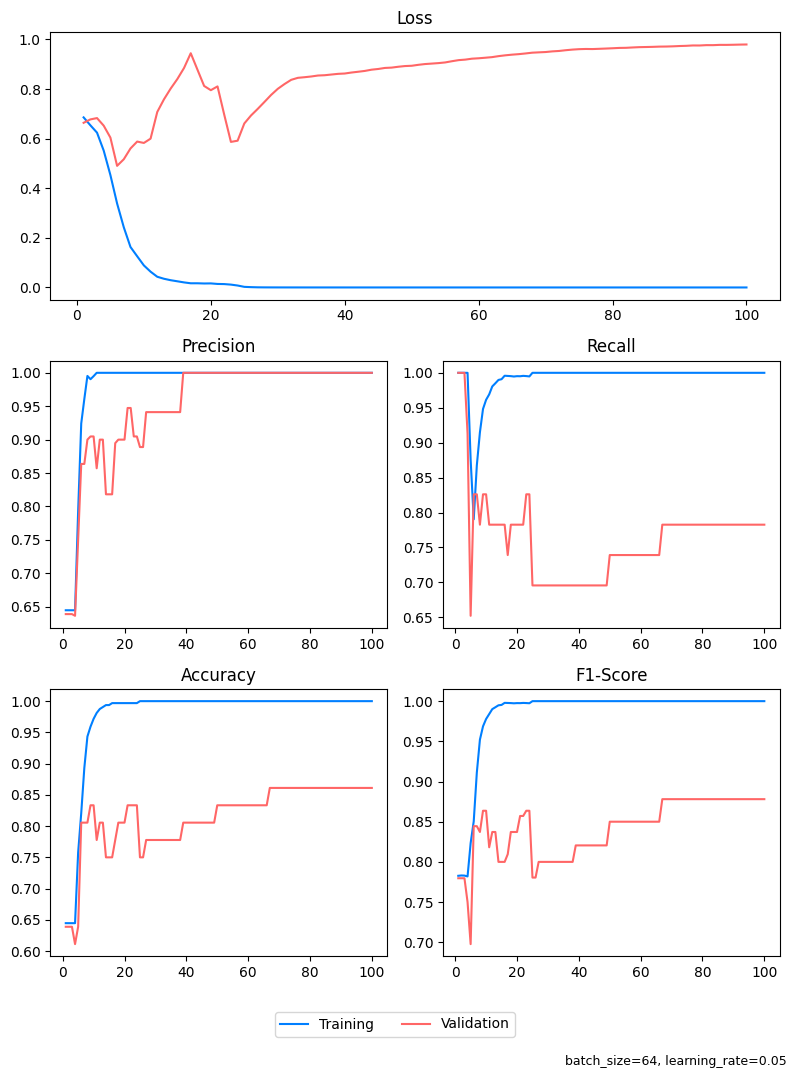

In [97]:
for bs in [32, 64]:
    for lr in [1e-2, 3e-2, 5e-2]:
        X_train_grid, X_val_grid, y_train_grid, y_val_grid = train_test_split(networks, se_targets, test_size=1/SPLIT, random_state=SEED)
        train_dataset = Dataset(X_train_grid, y_train_grid, batch_size=bs)
        val_dataset =  Dataset(X_val_grid, y_val_grid, shuffle=False)

        model = ClassicalModel.from_diagrams(networks)
        model.initialise_weights()

        trainer = PytorchTrainer(
                        model=model,
                        loss_function=torch.nn.BCEWithLogitsLoss(),
                        optimizer=torch.optim.AdamW,
                        learning_rate=lr,
                        epochs=EPOCHS,
                        evaluate_functions=eval_metrics,
                        evaluate_on_train=True,
                        verbose='text',
                        seed=SEED
                    )

        trainer.fit(train_dataset, val_dataset, log_interval=5)

        range_ = np.arange(1, len(trainer.train_epoch_costs) + 1)

        fig, axes = plt.subplot_mosaic('AA;BC;DE', figsize=(8, 10))

        axes['A'].plot(range_, trainer.train_epoch_costs, color=custom_primary, label='Training Loss')
        axes['A'].plot(range_, trainer.val_costs, color=custom_secondary, label='Validation Loss')
        axes['A'].set_title('Loss')

        axes['B'].plot(range_, trainer.train_eval_results['prec'], color=custom_primary, label='Training Precision')
        axes['B'].plot(range_, trainer.val_eval_results['prec'], color=custom_secondary, label='Validation Precision')
        axes['B'].set_title('Precision')

        axes['C'].plot(range_, trainer.train_eval_results['rec'], color=custom_primary, label='Training Recall')
        axes['C'].plot(range_, trainer.val_eval_results['rec'], color=custom_secondary, label='Validation Recall')
        axes['C'].set_title('Recall')

        axes['D'].plot(range_, trainer.train_eval_results['acc'], color=custom_primary, label='Training Accuracy')
        axes['D'].plot(range_, trainer.val_eval_results['acc'], color=custom_secondary, label='Validation Accuracy')
        axes['D'].set_title('Accuracy')

        axes['E'].plot(range_, trainer.train_eval_results['f1'], color=custom_primary, label='Training F1-Score')
        axes['E'].plot(range_, trainer.val_eval_results['f1'], color=custom_secondary, label='Validation F1-Score')
        axes['E'].set_title('F1-Score')

        for _, ax in axes.items():
            ax.legend().set_visible(False)

        fig.legend(['Training', 'Validation'], loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=2)
        plt.figtext(0.99, -0.07, f'batch_size={bs}, learning_rate={lr}', horizontalalignment='right', fontsize=9, color='black')

        plt.tight_layout()
        plt.savefig(f"/content/drive/MyDrive/Tesi/Master-Thesis/figures/grid-search/classical/binary/{bs}-{lr}.pdf", format="pdf", bbox_inches="tight")
        plt.show()

## K-fold cross validation
After grid-search we choose:

In [72]:
LEARNING_RATE = 3e-2
BATCH_SIZE = 64

In [82]:
cv = StratifiedKFold(n_splits=SPLIT, random_state=SEED, shuffle=True)
networks_np = np.array(networks, dtype=object)

for targets, label in [(se_targets, 'SE'), (us_targets, 'US'), (o_targets, 'O'), (pe_targets, 'PE')]:

    targets_np = np.array(targets, dtype=object)

    train_losses = []
    val_losses = []
    train_precisions = []
    val_precisions = []
    train_recalls = []
    val_recalls = []
    train_accuracies = []
    val_accuracies = []
    train_f1 = []
    val_f1 = []

    for i, (train_index, val_index) in enumerate(cv.split(networks_np, targets_np.argmax(1))):

        print(f'Processing Fold {i+1} ...')

        train_fold = Dataset(networks_np[train_index], targets_np[train_index], batch_size=BATCH_SIZE)
        val_fold = Dataset(networks_np[val_index], targets_np[val_index])

        model = ClassicalModel.from_diagrams(networks)
        model.initialise_weights()

        trainer = PytorchTrainer(
            model=model,
            loss_function=torch.nn.BCEWithLogitsLoss(),
            optimizer=torch.optim.AdamW,
            learning_rate=LEARNING_RATE,
            epochs=EPOCHS,
            evaluate_functions=eval_metrics,
            evaluate_on_train=True,
            verbose='text',
            seed=SEED
        )

        trainer.fit(train_fold, val_fold, log_interval=1, early_stopping_interval=EARLY_STOPPING)

        train_losses.append(trainer.train_epoch_costs)
        val_losses.append(trainer.val_costs)

        train_precisions.append(trainer.train_eval_results['prec'])
        val_precisions.append(trainer.val_eval_results['prec'])

        train_recalls.append(trainer.train_eval_results['rec'])
        val_recalls.append(trainer.val_eval_results['rec'])

        train_accuracies.append(trainer.train_eval_results['acc'])
        val_accuracies.append(trainer.val_eval_results['acc'])

        train_f1.append(trainer.train_eval_results['f1'])
        val_f1.append(trainer.val_eval_results['f1'])

    range_ = np.arange(1, len(trainer.train_epoch_costs) + 1)

    mean_train_loss = np.mean(train_losses, axis=0)
    min_train_loss = np.min(train_losses, axis=0)
    max_train_loss = np.max(train_losses, axis=0)

    mean_val_loss = np.mean(val_losses, axis=0)
    min_val_loss = np.min(val_losses, axis=0)
    max_val_loss = np.max(val_losses, axis=0)


    mean_train_precision = np.mean(train_precisions, axis=0)
    min_train_precision = np.min(train_precisions, axis=0)
    max_train_precision = np.max(train_precisions, axis=0)

    mean_val_precision = np.mean(val_precisions, axis=0)
    min_val_precision = np.min(val_precisions, axis=0)
    max_val_precision = np.max(val_precisions, axis=0)


    mean_train_recall = np.mean(train_recalls, axis=0)
    min_train_recall = np.min(train_recalls, axis=0)
    max_train_recall = np.max(train_recalls, axis=0)

    mean_val_recalls = np.mean(val_recalls, axis=0)
    min_val_recalls = np.min(val_recalls, axis=0)
    max_val_recalls = np.max(val_recalls, axis=0)


    mean_train_accuracy = np.mean(train_accuracies, axis=0)
    min_train_accuracy = np.min(train_accuracies, axis=0)
    max_train_accuracy = np.max(train_accuracies, axis=0)

    mean_val_accuracy = np.mean(val_accuracies, axis=0)
    min_val_accuracy = np.min(val_accuracies, axis=0)
    max_val_accuracy = np.max(val_accuracies, axis=0)


    mean_train_f1 = np.mean(train_f1, axis=0)
    min_train_f1 = np.min(train_f1, axis=0)
    max_train_f1 = np.max(train_f1, axis=0)

    mean_val_f1 = np.mean(val_f1, axis=0)
    min_val_f1 = np.min(val_f1, axis=0)
    max_val_f1 = np.max(val_f1, axis=0)


    fig, axes = plt.subplots(5, 2, figsize=(12, 18))

    axes[0, 0].set_title('Training Accuracy')
    axes[0, 0].set_xlabel('Iterations')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].plot(range_, mean_train_accuracy, color=custom_primary, label='Mean Accuracy')
    axes[0, 0].fill_between(range_, min_train_accuracy, max_train_accuracy, color=custom_primary, alpha=0.3)
    axes[0, 0].legend()

    axes[0, 1].set_title('Validation Accuracy')
    axes[0, 1].set_xlabel('Iterations')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].plot(range_, mean_val_accuracy, color=custom_secondary, label='Mean Accuracy')
    axes[0, 1].fill_between(range_, min_val_accuracy, max_val_accuracy, color=custom_secondary, alpha=0.3)
    axes[0, 1].legend()

    axes[1, 0].set_title('Training F1 Score')
    axes[1, 0].set_xlabel('Iterations')
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].plot(range_, mean_train_f1, color=custom_primary, label='Mean F1 Score')
    axes[1, 0].fill_between(range_, min_train_f1, max_train_f1, color=custom_primary, alpha=0.3)
    axes[1, 0].legend()

    axes[1, 1].set_title('Validation F1 Score')
    axes[1, 1].set_xlabel('Iterations')
    axes[1, 1].set_ylabel('F1 Score')
    axes[1, 1].plot(range_, mean_val_f1, color=custom_secondary, label='Mean F1 Score')
    axes[1, 1].fill_between(range_, min_val_f1, max_val_f1, color=custom_secondary, alpha=0.3)
    axes[1, 1].legend()

    axes[2, 0].set_title('Training Precision')
    axes[2, 0].set_xlabel('Iterations')
    axes[2, 0].set_ylabel('Precision')
    axes[2, 0].plot(range_, mean_train_precision, color=custom_primary, label='Mean Precision')
    axes[2, 0].fill_between(range_, min_train_precision, max_train_precision, color=custom_primary, alpha=0.3)
    axes[2, 0].legend()

    axes[2, 1].set_title('Validation Precision')
    axes[2, 1].set_xlabel('Iterations')
    axes[2, 1].set_ylabel('Precision')
    axes[2, 1].plot(range_, mean_val_precision, color=custom_secondary, label='Mean Precision')
    axes[2, 1].fill_between(range_, min_val_precision, max_val_precision, color=custom_secondary, alpha=0.3)
    axes[2, 1].legend()

    axes[3, 0].set_title('Training Recall')
    axes[3, 0].set_xlabel('Iterations')
    axes[3, 0].set_ylabel('Recall')
    axes[3, 0].plot(range_, mean_train_recall, color=custom_primary, label='Mean Recall')
    axes[3, 0].fill_between(range_, min_train_recall, max_train_recall, color=custom_primary, alpha=0.3)
    axes[3, 0].legend()

    axes[3, 1].set_title('Validation Recall')
    axes[3, 1].set_xlabel('Iterations')
    axes[3, 1].set_ylabel('Recall')
    axes[3, 1].plot(range_, mean_val_recalls, color=custom_secondary, label='Mean Recall')
    axes[3, 1].fill_between(range_, min_val_recalls, max_val_recalls, color=custom_secondary, alpha=0.3)
    axes[3, 1].legend()

    axes[4, 0].set_title('Training Loss')
    axes[4, 0].set_xlabel('Iterations')
    axes[4, 0].set_ylabel('Loss')
    axes[4, 0].plot(range_, mean_train_loss, color=custom_primary, label='Mean Loss')
    axes[4, 0].fill_between(range_, min_train_loss, max_train_loss, color=custom_primary, alpha=0.3)
    axes[4, 0].legend()

    axes[4, 1].set_title('Validation Loss')
    axes[4, 1].set_xlabel('Iterations')
    axes[4, 1].set_ylabel('Loss')
    axes[4, 1].plot(range_, mean_val_loss, color=custom_secondary, label='Mean Loss')
    axes[4, 1].fill_between(range_, min_val_loss, max_val_loss, color=custom_secondary, alpha=0.3)
    axes[4, 1].legend()

    plt.figtext(0.99, -0.07, f'{label} requirements', horizontalalignment='right', fontsize=10, color='black')

    plt.tight_layout()
    plt.savefig(f"/content/drive/MyDrive/Tesi/Master-Thesis/figures/classical/binary_{label}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

Processing Fold 1 ...


Epoch 1:   train/loss: 0.8059   valid/loss: 0.6643   train/prec: 0.6610   train/rec: 0.8162   train/acc: 0.5660   train/f1: 0.6449   valid/prec: 0.6389   valid/rec: 1.0000   valid/acc: 0.6389   valid/f1: 0.7797
Epoch 2:   train/loss: 0.6255   valid/loss: 0.6377   train/prec: 0.6447   train/rec: 1.0000   train/acc: 0.6447   train/f1: 0.7833   valid/prec: 0.6389   valid/rec: 1.0000   valid/acc: 0.6389   valid/f1: 0.7797
Epoch 3:   train/loss: 0.6127   valid/loss: 0.6290   train/prec: 0.6447   train/rec: 1.0000   train/acc: 0.6447   train/f1: 0.7820   valid/prec: 0.6389   valid/rec: 1.0000   valid/acc: 0.6389   valid/f1: 0.7797
Epoch 4:   train/loss: 0.5573   valid/loss: 0.6935   train/prec: 0.6447   train/rec: 1.0000   train/acc: 0.6447   train/f1: 0.7817   valid/prec: 0.6389   valid/rec: 1.0000   valid/acc: 0.6389   valid/f1: 0.7797
Epoch 5:   train/loss: 0.4457   valid/loss: 0.8691   train/prec: 0.6959   train/rec: 0.9567   train/acc: 0.6887   train/f1: 0.7996   valid/prec: 0.8000   va

KeyboardInterrupt: ignored